Data loaded & cleaned. Shape: (7032, 20)
Feature engineering done + redundant columns dropped

Churn rate:
Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64
Split done → Train: 4218, Val: 1407, Test: 1407

Training & comparing models...
Logistic Regression: Validation Churn F1 = 0.6279
Random Forest: Validation Churn F1 = 0.5216
XGBoost: Validation Churn F1 = 0.5962

Best model on Validation: Logistic Regression (F1 = 0.6279)
Best threshold (from Validation): 0.480 (F1 = 0.6303)

FINAL RESULTS - (Best Model: Logistic Regression, Optimized Threshold)
              precision    recall  f1-score   support

    No Churn       0.90      0.70      0.79      1033
       Churn       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407



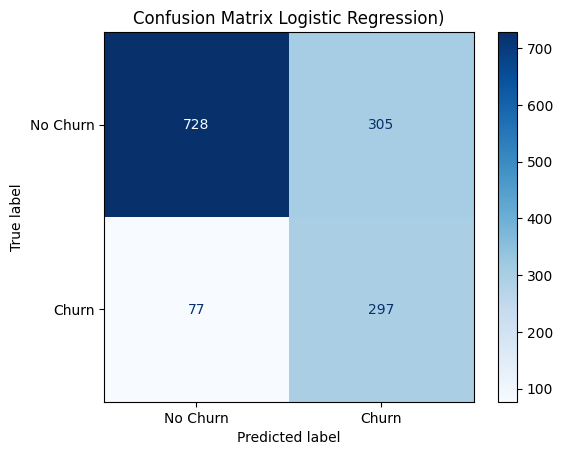

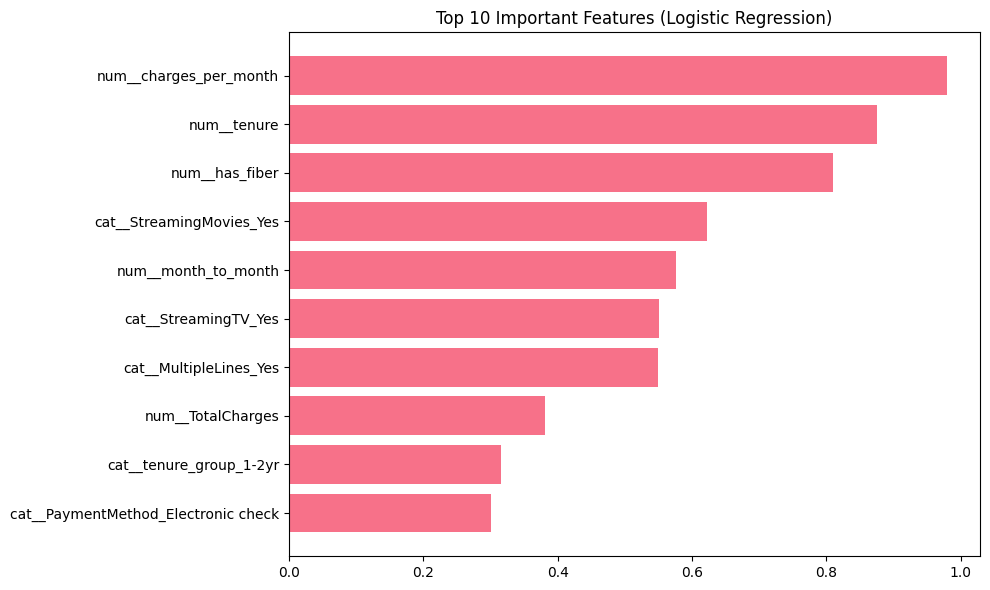


Model & plots saving successful


In [12]:
# ============================================
# TELCO CUSTOMER CHURN PREDICTION -

# 1. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import joblib

plt.style.use('default')
sns.set_palette("husl")


# 2. LOAD & BASIC CLEANING

df = pd.read_csv("Telco-Customer-Churn.xls")
df = df.drop("customerID", axis=1)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df = df.dropna()
print("Data loaded & cleaned. Shape:", df.shape)

# 3. FEATURE ENGINEERING

df["tenure_group"] = pd.cut(df["tenure"], bins=[0, 12, 24, 48, 72],
                           labels=["0-1yr", "1-2yr", "2-4yr", "4+yr"])

df["charges_per_month"] = df["TotalCharges"] / (df["tenure"] + 1)
df["has_fiber"] = (df["InternetService"] == "Fiber optic").astype(int)
df["month_to_month"] = (df["Contract"] == "Month-to-month").astype(int)

# Dropping original columns to avoid duplicate info
df = df.drop(["InternetService", "Contract"], axis=1)
print("Feature engineering done + redundant columns dropped")

# 4. CHECK IMBALANCE

print("\nChurn rate:")
print(df["Churn"].value_counts(normalize=True))

# 5. SPLIT FEATURES & TARGET

X = df.drop("Churn", axis=1)
y = df["Churn"].map({"No": 0, "Yes": 1})   # Converting to 0/1

# 6. PROPER TRAIN / VALIDATION / TEST SPLIT (60% / 20% / 20%)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)

print(f"Split done → Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# 7. PREPROCESSING PIPELINE (OneHot + Scaling)

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

# 8. DEFINE MODELS TO COMPARE (easy to add more here)

# each model handles imbalance: class_weight or scale_pos_weight
models = {
    "Logistic Regression": Pipeline([
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(class_weight="balanced", max_iter=1000))
    ]),
    "Random Forest": Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=200))
    ]),
    "XGBoost": Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]),
            random_state=42, eval_metric="logloss", n_estimators=200, max_depth=6, learning_rate=0.1
        ))
    ])
}

# 9. TRAIN & COMPARE ON VALIDATION SET

results = {}
best_model_name = None
best_f1_val = 0
best_pipeline = None

print("\nTraining & comparing models...")
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)   # Training on Train set
    y_pred_val = pipeline.predict(X_val)   # Predicting on Validation
    f1_val = f1_score(y_val, y_pred_val, pos_label=1)
    results[name] = f1_val
    print(f"{name}: Validation Churn F1 = {f1_val:.4f}")

    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_model_name = name
        best_pipeline = pipeline

print(f"\nBest model on Validation: {best_model_name} (F1 = {best_f1_val:.4f})")

# 10. THRESHOLD TUNING ON VALIDATION SET (using best model)

y_probs_val = best_pipeline.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)
best_thresh_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred_val_thresh = (y_probs_val >= thresh).astype(int)
    current_f1 = f1_score(y_val, y_pred_val_thresh, pos_label=1)
    if current_f1 > best_thresh_f1:
        best_thresh_f1 = current_f1
        best_thresh = thresh

print(f"Best threshold (from Validation): {best_thresh:.3f} (F1 = {best_thresh_f1:.4f})")

# 11. FINAL PREDICTION ON TEST SET (unseen data)

y_probs_test = best_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_probs_test >= best_thresh).astype(int)

# 12. FINAL RESULTS (this is what you show on portfolio)

print("\n" + "="*50)
print(f"FINAL RESULTS - (Best Model: {best_model_name}, Optimized Threshold)")
print("="*50)
print(classification_report(y_test, y_pred, target_names=["No Churn", "Churn"]))

# 13. SAVING PLOTS & MODEL

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix {best_model_name})")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Feature Importance (Top 10) - Only if best model supports it (RF or XGBoost)
model = best_pipeline.named_steps["model"]

if hasattr(model, "feature_importances_") or hasattr(model, "coef_"):

    feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        importances = np.abs(model.coef_[0])

    top_idx = np.argsort(importances)[-10:]

    plt.figure(figsize=(10, 6))
    plt.barh(range(10), importances[top_idx])
    plt.yticks(range(10), feature_names[top_idx])
    plt.title(f"Top 10 Important Features ({best_model_name})")
    plt.tight_layout()
    plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")
    plt.show()

joblib.dump(best_pipeline, "churn_model.pkl")
print("\nModel & plots saving successful")

In [ ]:
importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values().plot(kind='barh')
plt.show()

In [15]:
from google.colab import files

# Download the model
files.download('churn_model.pkl')

# Download the plots
files.download('confusion_matrix.png')
files.download("feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>